In [1]:
import numpy as np
import pandas as pd 
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
print(os.listdir("/home/jupyter/fashion_mnist/"))

['train.csv', 'train', 'test.csv', 'More experimentation.ipynb', 'test', '.ipynb_checkpoints', 'Identify the apparels.ipynb']


In [3]:
main_path = Path('/home/jupyter/fashion_mnist/')
main_path.ls()

[PosixPath('/home/jupyter/fashion_mnist/train.csv'),
 PosixPath('/home/jupyter/fashion_mnist/train'),
 PosixPath('/home/jupyter/fashion_mnist/test.csv'),
 PosixPath('/home/jupyter/fashion_mnist/More experimentation.ipynb'),
 PosixPath('/home/jupyter/fashion_mnist/test'),
 PosixPath('/home/jupyter/fashion_mnist/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/fashion_mnist/Identify the apparels.ipynb')]

In [4]:
train = pd.read_csv(main_path/'train.csv')
sub_file = pd.read_csv(main_path/'test.csv')

In [5]:
train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [25]:
test_img = ImageList.from_df(sub_file, path=main_path, folder='test', suffix='.png')

databunch = ImageList.from_df(train, path=main_path, folder='train', suffix='.png')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .add_test(test_img)\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=256, device= torch.device('cuda:0'))\
            .normalize()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


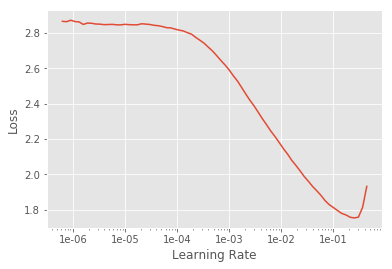

In [8]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[error_rate, accuracy]).to_fp16()
learner.lr_find();
learner.recorder.plot()

In [9]:
learner.fit_one_cycle(5, max_lr=slice(3e-02, 5e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.579010,0.526368,0.190333,0.809667,00:29
1,0.453953,0.337880,0.116167,0.883833,00:27
2,0.401866,0.382176,0.140167,0.859833,00:27
3,0.340926,0.281292,0.100167,0.899833,00:28
4,0.296667,0.253347,0.095667,0.904333,00:27


In [10]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(3e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.482513,0.571406,0.163667,0.836333,00:35
1,0.468374,0.484480,0.153833,0.846167,00:34
2,0.387968,0.347960,0.116167,0.883833,00:35
3,0.310592,0.249811,0.093833,0.906167,00:34
4,0.260585,0.226413,0.082333,0.917667,00:34


In [12]:
learner.lr_range(slice(3e-02, 5e-03)), learner.lr_range(slice(5e-03))

(array([0.03    , 0.012247, 0.005   ]), array([0.0005, 0.0005, 0.005 ]))

In [13]:
learner.freeze()
learner.fit_one_cycle(5, max_lr=(1e-4, 5e-3, 3e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.270589,0.240445,0.082833,0.917167,00:28
1,0.296739,0.253274,0.083500,0.916500,00:28
2,0.268779,0.236513,0.084000,0.916000,00:28
3,0.262605,0.219513,0.078667,0.921333,00:28
4,0.245839,0.220802,0.079167,0.920833,00:28


In [15]:
learner.save('stage-1-rn50')

In [26]:
learner = cnn_learner(databunch, models.resnet50, 
                      metrics=[error_rate, accuracy]).to_fp16().load('stage-1-rn50')

learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.251058,0.214602,0.082167,0.917833,00:27
1,0.246593,0.207863,0.081500,0.918500,00:28
2,0.248205,0.221908,0.079500,0.920500,00:27


In [27]:
labels = []

for i in range(len(databunch.test_ds)):
    pred_class, _, _ = learner.predict(databunch.test_ds[i][0])
    labels.append(pred_class)
    
labels = list(map(lambda x: str(x).replace('Category', ''), labels))

sub_file['label'] = labels
sub_file.to_csv('submission.csv', index=False)

In [45]:
train_features = learner.get_preds(ds_type= DatasetType.Fix)

In [41]:
train_features[0].shape

torch.Size([54000, 10])

In [46]:
train_features = train_features[0].numpy()

In [51]:
train_labels = []
for i in range(len(databunch.train_ds)):
    train_label = str(databunch.train_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
    train_labels.append(train_label)

train_labels[:10]

['9', '0', '0', '3', '0', '2', '7', '2', '5', '5']

In [55]:
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

y = lb.fit_transform(train_labels)
y = keras.utils.to_categorical(y)

In [74]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain

logreg = LogisticRegression(solver='saga')
multi_label_logreg = ClassifierChain(logreg)
multi_label_logreg.fit(train_features, y)

ClassifierChain(classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
        order=None, require_dense=[True, True])

In [61]:
test_features = learner.get_preds(ds_type= DatasetType.Test)

In [75]:
predictions = multi_label_logreg.predict(test_features[0].numpy())

In [76]:
predIdxs = np.argmax(predictions, axis=1)

In [77]:
sub_file['label'] = lb.inverse_transform(predIdxs)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
sub_file.to_csv('submission.csv', index=False)